# Introdução
- Detalhamento do problema e visão geral sobre o funcionamento do programa

O desafio proposto nesse trabalho prático consiste em fazer com que dois robôs móveis com caracteristicas bem definidas se locomoveseem em ambientes que possuiem vários obstáculos, cada robô deverá utilizar um algoritmo de planejamento de caminhos sendo eles roadmap e campos potenciais, sendo eles um algoritmo deleberativo e o outro reativo respectivamente, para partirem de uma posição inicial até a posição objetivo.

Para que o robô consiga realizar essa tarefa é necessário dois componemtes importantissimos um modulo para o planejamento de caminho e outro módulo responsável pelo controle do robô.

Rôbo Diferencial (Pioneer) + Algoritmo de Campos Potencias:
    O algoritmo de Campos Potencias utiliza como inspiração a conceito de forças (atração e repulsão) da física, possuindo essas duas forças é possivel fazer o planejamento do Caminho reslizado pelo robô, e portanto para implementa-lo é necessário calcular essas forças.
        - Força de atração  é uma força que é aplicado no robô em direção e sentido ao Goal (Objetivo)
        - Força de repulsão é uma força que é aplicado no robô quando o mesmo se aproxima de um obstáculo, essa força tem sentido oposto do obstáculo, ao aplicar esse força no robô resulta em afasta-lo do objeto
    
    Nesse notebook foi impletado funções responsável por calcular a força de atração e repulsão. E uma outra função que as invoca e calcula a força resultante (soma das forças de atração e repulsão).

    A força resultante informa para o robô qual é o proximo passo que ele deve realizar, para que o mesmo possa chegar no Goal(objetivo). Porém para que o robô se mova se necessário que haja um controlador que receba como entrada o vetor de força resultade e o converta para parametros de controle do robô



# Implementação

## Modules Used

Modulo responsável pela comunicação com o CoppeliaSim

In [146]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

Modulos Usados para Nesse trabalho prático

In [147]:
# Other Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import networkx as nx
from copy import deepcopy
from time import sleep, time

## Pegando as dimensões do mapa do Coppelia

Exemplo de como se conectar no Coppelia

In [148]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

floorHandle = sim.getObject("/heightfield")
_, _, info = sim.getShapeGeomInfo(floorHandle)

sim.stopSimulation()
sleep(1)


In [149]:
print('x, y, z = ', info[:3])

x, y, z =  [25.0, 25.0, 1.9921875]


## Funções Auxiliares (Implementadas no TP1)
- Funções para calcular a tranformada
- Funçõa para calcular a inversa de uma transformada

#### Codding to calculate the Transformation Matrix

In [150]:
# Function that invert a matrix
def invertMatrix(M):
    return np.linalg.inv(M)

In [151]:
# Get Object Position and Orientation
def getPositionAndOrientation(handle, referenceTo):
    pos = sim.getObjectPosition(handle, referenceTo)
    ori = sim.getObjectOrientation(handle, referenceTo)
    return pos, ori

In [152]:
# Get Rotation Matrix fixed on Z axis
def getRotationMatrixZfixed(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [153]:
# get the transformation from local axis to a reference axis
# the default reference axis is the global/world axis
def getTransformationMatrix(handle, referenceTo=sim.handle_world):
    # Get the object position and orientation
    pos, ori = getPositionAndOrientation(handle, referenceTo)
    # Get the Rotation Matrix
    rotM = getRotationMatrixZfixed(ori[2])
    scale = np.array([0, 0, 0, 1])

    # Create the transformation Matrix
    tranfMatrix = np.column_stack((rotM, pos))
    tranfMatrix = np.row_stack((tranfMatrix, scale))

    return tranfMatrix



#### Função que lê os dados coletados pelo sensor do Laser

In [154]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id, sim.simx_opmode_streaming)
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id)

    # print(range_data_signal_id)
    resultCodeRanges = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    # returnCodeAngles, string_angle_data = sim.simxGetStringSignal(angle_data_signal_id, sim.simx_opmode_blocking)
    
    resultCodeAngles = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if resultCodeRanges != None and resultCodeAngles != None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(resultCodeRanges)
        raw_angle_data = sim.unpackFloatTable(resultCodeAngles)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None


## Campos Potenciais Calculo das forças
- Definição de Variáveis
- Funções Responsáveis pelo calculo da força
- Teste dessas funções

### Força de Atração

#### Variáveis Usadas

In [155]:
K_att = 1.5 # Constante proporcional usado na força de atração

#### Função Responsável por calcular a força de Atração

Formula retirada do slide 11 da aula 12 planejamento de caminho Campos Potenciais

![attraction_force](documentation/attraction_force.png)

In [156]:
def attraction_force(position, goal, K=0.1):
    # Retorna somente as posições x e y
    return (K * (goal - position))[:2]

#### Teste da Força de atração

Connected to remote API server
força de atração é:  [21.25328168 26.36262167]


força de atração resultante (usando transformação):  [-28.57155978 -34.59609195]


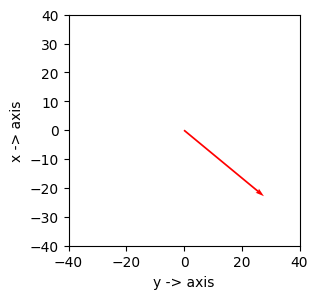

In [157]:
import time
sim.startSimulation()

print ('Connected to remote API server')

####################  Obtem os Handles dos Objetos ##############

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)     

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

###################  Obtem a Posição do Robô e do Goal #############

# Pega a posição do Robo
robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
# Pega a posição do Goal
goalPosition = np.asarray(sim.getObjectPosition(goalHandle))
# print('robot position: ', robotPosition)
# print('goal position: ', goalPosition)


################# Força de Atração ###################

# Calcula a Força de Atração
f_att = attraction_force(robotPosition, goalPosition, K_att)
print('força de atração é: ', f_att)

sim.stopSimulation()
sleep(1)

# Transforma o vetor de atração do referencial do Mundo 
# Para o Referencial do Robô
## Calcula a matriz de tranformação do robô para o mundo
Tranformation_robot_to_world = getTransformationMatrix(robotHandle)
## Calcula a matriz de transformação do mundo para o robô
Tranformation_world_to_robot = invertMatrix(Tranformation_robot_to_world)
## Aplica a matriz de transformação
Fatt = Tranformation_world_to_robot @ np.asarray([f_att[0], f_att[1], 0, 1])
print('força de atração resultante (usando transformação): ', Fatt[:2])


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Os eixos do coppelia em relação do matplot lib são invertidos
# Coppelia eixo X = MatplotLib eixo Y e vice versa
# O eixo Y (ou eixo X do Matplot) do robo tem uma direção diferente do Matplot lib e portanto multiplicamos o eixo por -1
# Cresce para a esquerda e decresce indo para a direita
ax.quiver(*[0, 0], -Fatt[1], Fatt[0], color=['r','b','g'], scale=100)

ax.set_xlabel("y -> axis")
ax.set_ylabel("x -> axis")

ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

plt.show()

### Força de Repulsão

#### Variáveis Utilizadas

In [158]:
K_rep = 0.1
gamma = 2 # Valor recomendado pelo professor no Forum da Disciplina
p0 = 3 # Limiar utiliazado

#### Função da força de Repulsão

![repulsion_force](documentation/repulsion_force.png)

- A parte em vermelho resulta em um valor escalar
- A parte em azul da equação resulta em um vetor

Adaptação da parte em azul da formula:

$\dfrac{q - q_{obs, i}}{p_i(q)}$   ->   $\dfrac{\text{posição de impacto do laser em relação ao robô} * -1}{p_i(q)}$

Multiplicamos por -1, pois o laser retorna um vetor que possui sentido do robô para o objeto. E portanto ao multiplicar por -1 invertemos o sentido para conseguir o vetor unitário do obstáculo para o robô.

In [159]:
def repulsion_force(laser_data, K, gamma=2, threshold=2):
    # Pega somente os dados que atendem a condição de terem uma distancia menor que o limiar
    filter = laser_data[:, 1] < threshold
    data = laser_data[filter]
    
    # separa os dados em angulos e distancias
    distaces = data[:, 1]
    angles = data[:, 0]

    # angles += angles.mean() * 2

    # Calcula a parte escalar da formulada força de recursão
    escalar = K / (distaces**2)
    escalar *= (1/distaces) - 1/threshold

    # Calcula a parte vetorial da formula da força de repulsão
    # Calcula o deslocamento no eixo x e no eixo y
    # Eixo x
    axis_x = distaces * np.cos(angles)
    # Eixo y
    axis_y = distaces * np.sin(angles)
    
    delta_x = sum(escalar * (axis_x / distaces))
    delta_y = sum(escalar * (axis_y / distaces))
    
    # Multiplico por -1, para calcular
    return np.asarray([-delta_x, -delta_y])



#### Teste da força de repulsão

In [160]:
sim.startSimulation()

print ('Connected to remote API server')
    
##### Obtem os Handles ####

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)   

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"


# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')  


# Parando o robô    
# Por algum motivo, no inicio da simulação o robô anda sozinho
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)  


###### Leitura do dados Obtidos Pelo Laser #####

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas
range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

####################  Calcula a força de repulsão ######################

# Pega a posição do Robo
robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
# print('robot position: ', robotPosition)

# Calcula a tranformada responsável por tranformados os dados do Laser
# Que estão no referencial do laser para o referencial do Robô
tranformation_laser_to_robot = getTransformationMatrix(laserHandle, robotHandle)

# Calcula a força de repulsão
f_rep = repulsion_force(laser_data, K_rep, gamma, p0)
# Realiza a transformação
f_rep = tranformation_laser_to_robot @ np.asarray([f_rep[0], f_rep[1], 0, 1])
# Pega somente os eixos x e y
f_rep = f_rep[:2]

sim.stopSimulation()
sleep(1)
    
print ('Program ended')

Connected to remote API server
Program ended


Faz o print do test

[-1.25898727 -1.77881265]


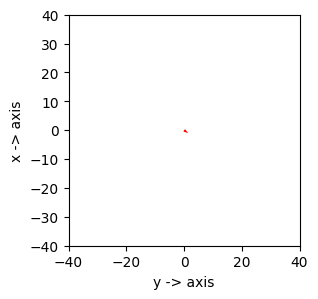

In [161]:
print(f_rep)
fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Os eixos do coppelia em relação do matplot lib são invertidos
# Coppelia_X = MatplotLib_Y e vice versa
# O eixo Y (eixo X do Matplot) do robo tem uma direção diferente do Matplot lib e portanto multiplicamos o eixo por -1
plt.quiver(*[0, 0], -f_rep[1], f_rep[0], color=['r','b','g'], scale=100)

ax.set_xlabel("y -> axis")
ax.set_ylabel("x -> axis")

ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

plt.show()

### Vetor de Força Resultante

Função que calcula tanto o vetor de força de atração quanto o vetor de força de repulsão

In [162]:
def resultant_force(robotHandle, goalHandle, laserRangeDataHandle, laserAngleDataHandle):
    # Pega a posição do Robo e do goal
    robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
    goalPosition = np.asarray(sim.getObjectPosition(goalHandle))

    ####################  Calcula a força de Repulsão   ######################
    
    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas
    range_data = None
    while range_data == None:
        range_data = sim.getStringSignal(laser_range_data)
        sim.step()

    # Prosseguindo com as leituras
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    

    ### Variáveis Globais: K_rep, gamma, p0
    f_rep = repulsion_force(laser_data, K_rep, gamma, p0)

    #################### Calcula a força de atração ###################

    ### Calcula a matrix de tranformação
    ### Que convert um ponto do referencial do mundo para o referencial do robô
    Tranformation_robot_to_world = getTransformationMatrix(robotHandle)
    Tranformation_world_to_robot = invertMatrix(Tranformation_robot_to_world)

    ### K_att -> Variavel Global
    Fatt = attraction_force(robotPosition, goalPosition, K_att)

    # Transforma o vetor de atração para o referencial do robo
    Fatt = Tranformation_world_to_robot @ np.asarray([Fatt[0], Fatt[1], 0, 0])
    f_att = Fatt[:2]

    print('att: ', f_att)
    print('rep: ', f_rep)

    return f_att + f_rep



## Controlador

In [163]:
def controlador(dx, dy, robotOrientation):

    # Variáveis de proporcionalidade  
    KPr = 0.5
    KPt = 0.5

    # # Variáveis derivativas
    # KDr = 2
    # KDt = 0.5

    # Calcula as velocidades
    # Velocidade Linear Proporcional
    # uPr = dx*np.cos(robotOrientation) + dy*np.sin(robotOrientation)
    # uPr *= KPr
    uPr = (dx + dy) * KPr

    # # Velocidade Linear Derivada
    # uDr = dx_D*np.cos(robotOrientation) + dy_D*np.sin(robotOrientation)
    # uDr *= KDr

    # Velocidade Angular Proporcional 
    # uPt = (np.arctan2(dy,dx) - robotOrientation)
    # uPt *= KPt
    uPt = np.arctan2(dy,dx) * KPt
    # Explicar pq eu multipliquei por -1
    uPt *= -1
    # print(uPt)

    # # Velocidade Angular Derivada
    # uKt = np.arctan2(dy_D,dx_D) - robotOrientation
    # uKt *= KDt
    
    # v -> velocidade Linear
    # w -> Velocidade Angular
    v = uPr #+ uDr
    w = uPt #+ uKt

    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw) 

    # Impede do robo andar para trás
    # Melhora a performace
    # Motivo: Ele tem sensor na parte da frente, então andar de ré não faz sentido
    if (v < 0): v = 0
            
    # Objetivo: quero que o robô ajuste primeiro a sua posição em relação ao objetivo 
    # E dps se movimente para ele
    # if(w > np.deg2rad() or w < np.deg2rad(315) ) and rho > 1)

    # if (w > np.deg2rad(10) and w < np.deg2rad(45) ) and rho > 1:
    #     v = 0
    # if (w < np.deg2rad(-10) and w > np.deg2rad(-45) ) and rho > 1:
    #     v = 0
        

    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)

    return vr, vl

# Testes

### Dados do Robô

In [164]:
# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 0.5
maxw = np.deg2rad(45)

### Executa a Simulação

In [165]:
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

print ('Connected to remote API server')

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)    

# Handle para o Goal
goalname = "/Goal"
goalHandle = sim.getObject(goalname)

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas
range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    # sim.step() responsável por sincronizar com a emulação
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

# Para o robô
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)   

startTime=time.time()
lastTime = startTime
t = 0
rho = 1
while rho > 0.5:

    robotPosition = np.asarray(sim.getObjectPosition(robotHandle)) 
    goalPosition = np.asarray(sim.getObjectPosition(goalHandle))

    dx, dy = (goalPosition - robotPosition)[:2]
    rho = np.sqrt(dx**2 + dy**2)
    
    now = time.time()
    dt = now - lastTime

    dx, dy = resultant_force(robotHandle, goalHandle, laser_range_data, laser_angle_data)
    print(dx, dy)
    robotOrientation = sim.getObjectOrientation(robotHandle)
    
    vr, vl = controlador(dx, dy, robotOrientation[2])
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, vr)
    sim.setJointTargetVelocity(r_wheel, vl)        

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)        
    
sim.stopSimulation()

print ('Program ended')

Connected to remote API server
att:  [-23.4538367  -24.42554703]
rep:  [-1.30934073 -1.83086995]
-24.763177425188047 -26.256416980152473
att:  [-23.43728788 -24.44142673]
rep:  [-1.3646438  -1.89106166]
-24.801931678703255 -26.33248838674861
att:  [-23.2811759  -24.58998974]
rep:  [-1.34286914 -1.87944492]
-24.624045034081487 -26.469434657890034
att:  [-23.11590299 -24.74420495]
rep:  [-1.35195366 -1.86819562]
-24.46785665109436 -26.612400568288333
att:  [-22.75499869 -25.07700948]
rep:  [-1.3567641  -1.83644488]
-24.11176279776074 -26.913454355814267
att:  [-22.14332275 -25.62123319]
rep:  [-1.34298316 -1.79258557]
-23.486305908428758 -27.41381875977814
att:  [-21.32499973 -26.30891886]
rep:  [-1.31432244 -1.73575821]
-22.639322165100875 -28.044677065540274
att:  [-20.54982985 -26.92040886]
rep:  [-1.30080707 -1.66918051]
-21.850636927037005 -28.589589377288576
att:  [-19.66729061 -27.57073246]
rep:  [-1.29217341 -1.60560425]
-20.95946402033664 -29.176336709134844
att:  [-18.63742443 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Conclusão
- comentários gerais sobre o trabalho e as principais dificuldades encontradas.

O algoritmo de campos potenciáis usando o paradigma reativo, apesar de ter me surpreendido bastante, pois apresentou um resultado muito bom no mapa 01, conseguiu concluir o desafio sem dificuldade. No mapa 02 depedendo da posição de escolhida para o robô e o objetivo, durante a execução do desafio muitas vezes o robô ficava preso em um minimo local.

Desafios Encontrados:
- Adaptar o controlador, utilizei como referencia o controlador implementado pelo professor e disponivel no github da disciplina. Esse controlador utiliza em seus cálculos a orientação do robô em relação ao mundo, porém como estou usando a abordagem reativa optei por fazer um controlador que dependece somente do referencial do robô.
- Ajustar as constantes utilizados no calculo das forças de atração e repulsão, realização de muitos testes empiricos
- Eixo Y do robô (pioneer) é invertido, isso complicou um pouco as coisas kkkkk.

# Biografia
- Slides da Aula 12
- Jupyter Notebook da Aula 12